In [ ]:
!unzip nlp-getting-started.zip

Archive:  nlp-getting-started.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In this project, we will employ a Long Short-Term Memory (LSTM) approach to analyze tweets and determine if they correspond to real-life emergencies. By leveraging labeled data, our machine learning algorithm will classify the tweets and identify patterns or expressions indicative of actual disasters. We will begin by importing the necessary libraries, with TensorFlow Keras serving as the foundation for the natural language processing (NLP) component of our model.

In [ ]:
#general libraries
import numpy as np
import pandas as pd
import os
import re
import string

#visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#model development
from keras import preprocessing
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization
from keras.models import Sequential
import tensorflow as tf
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

In [ ]:
nlp_train = pd.read_csv('/content/train.csv')
nlp_test = pd.read_csv('/content/test.csv')

# **Exploratory Data Analysis**

To begin our EDA, we will print the training dataset's information, including data types and non-null counts, followed by similar details for the testing dataset. This will help us confirm that the datasets are correctly loaded and identify any potential issues with missing values or data types. Next, we will preview the first few rows of both datasets to examine their format and ensure that the data is organized as expected, providing a clear view of how the features and labels are presented in each dataset.








In [ ]:
print("\n----- Training information-----")
print(nlp_train.info())
print("\n----- Testing information-----")
print(nlp_test.info())
print("\n----- Training format-----")
print(nlp_train.head())
print("\n----- Testing format-----")
print(nlp_test.head())


----- Training information-----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None

----- Testing information-----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB
None

----- Training format-----
   id keyword location                                               text  \
0   1     

In [ ]:
print("\n----- Training Null counts -----")
print(nlp_train.isnull().sum())
print("\n----- Testing Null counts -----")
print(nlp_test.isnull().sum())


----- Training Null counts -----
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

----- Testing Null counts -----
id             0
keyword       26
location    1105
text           0
dtype: int64



The training dataset comprises 7,613 entries and includes five columns: id, keyword, location, text, and target, where the target column serves as the label for each tweet, distinguishing between disaster-related and non-disaster-related tweets. The test dataset, which contains 3,263 entries, includes similar columns but omits the target column, as it is intended for prediction rather than training. In both datasets, there are notable missing values in the keyword and location columns. Specifically, the training set has 61 missing values in the keyword column and a substantial 2,533 missing values in the location column. Similarly, the test set has 26 missing values in the keyword column and 1,105 missing values in the location column.

In [ ]:
nlp_train.drop('location', axis=1, inplace=True)
nlp_test.drop('location', axis=1, inplace=True)
nlp_train.drop('keyword', axis=1, inplace=True)
nlp_test.drop('keyword', axis=1, inplace=True)

These missing values are significant and have been addressed by removing these columns, as they are not critical to the analysis and would otherwise complicate the data preprocessing. This cleanup allows us to focus on the essential data for building and evaluating our machine learning model.

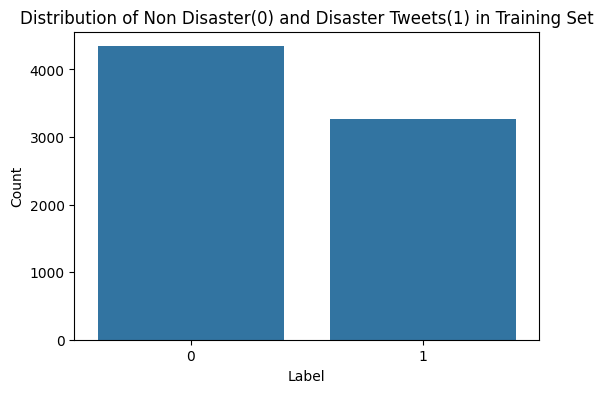

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=nlp_train)
plt.title('Distribution of Non Disaster(0) and Disaster Tweets(1) in Training Set')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

A histogram of the target labels reveals a slight imbalance: there are just over 4,000 non-disaster tweets and a little more than 3,000 disaster tweets. This imbalance indicates a predominance of non-emergency tweets, which could potentially lead to overfitting the model to negative cases. Therefore, it's crucial to consider strategies during training to mitigate this risk. One option might be to split the data more evenly between the two classes to ensure that the model is equally effective at identifying both disaster-related and non-disaster-related tweets.

### **PreProcessing**

To prepare the data for model training, we will start by addressing class imbalance in the training dataset. We will achieve this by performing undersampling, where we reduce the number of samples from the majority class (non-disaster tweets) to match the number of samples in the minority class (disaster tweets). This ensures a balanced dataset for more effective model training. After balancing the classes, we will convert the text data and labels from the DataFrame to NumPy arrays for compatibility with machine learning libraries.

Next, we will preprocess the text data to enhance the quality of input for our model. This involves several steps: removing URLs, hashtags, and punctuation, as well as filtering out common English stop words to focus on meaningful content. The cleaned text will then be further refined using stemming to reduce words to their root forms, which helps in normalizing the text data. We will tokenize the text using TensorFlow's Tokenizer, which will convert the text into sequences of integers representing words, and determine the vocabulary length. Finally, we will identify the longest sentence in the dataset to understand the text length, which will inform how we handle padding and sequence length during model training.

In [ ]:
class_0 = nlp_train[nlp_train['target'] == 0]
class_1 = nlp_train[nlp_train['target'] == 1]
class_0_under = class_0.sample(len(class_1), random_state=42)
nlp_train = pd.concat([class_0_under, class_1])

In [ ]:
text = nlp_train['text']
text = text.to_numpy()
label = nlp_train['target']
label = label.to_numpy()
text

array(['Everyday is a near death fatality for me on the road. Thank god is on my side.??',
       '#Lifestyle \x89Û÷It makes me sick\x89Ûª: Baby clothes deemed a \x89Û÷hazard\x89Ûª http://t.co/0XrfVidxA2 http://t.co/oIHwgEZDCk',
       '@Lenn_Len Probably. We are inundated with them most years!', ...,
       'M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ',
       'Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries.',
       'The Latest: More Homes Razed by Northern California Wildfire - ABC News http://t.co/YmY4rSkQ3d'],
      dtype=object)

In [ ]:
def clean(text_array):
    def process_sentence(sentence):
        sentence = re.sub(r'http\S+|www\S+|https\S+', '', sentence, flags=re.MULTILINE)
        sentence = re.sub(r'#\S+', '', sentence)
        sentence = sentence.translate(str.maketrans('', '', string.punctuation))
        words = sentence.split()
        filtered_words = [word for word in words if word.lower() not in ENGLISH_STOP_WORDS]
        return ' '.join(filtered_words)
    return [process_sentence(sentence) for sentence in text_array]
text = clean(text)

In [ ]:
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer("english")
text = [stemmer.stem(word) for word in text]

In [ ]:
word_tokenizer = tf.keras.preprocessing.text.Tokenizer()
word_tokenizer.fit_on_texts(text)
vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

15369

In [ ]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
longest_train = max(text, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# **Model**

For our model, we will construct and train a Long Short-Term Memory (LSTM) network to classify tweets into disaster-related or non-disaster-related categories. We begin by defining parameters for our model, including max_words to set the vocabulary length and max_len to determine the length of the input sequences. We then convert the text data into sequences of integers using a word tokenizer and pad these sequences to ensure uniform input length. The labels are transformed into categorical format to align with the model's output requirements. The model architecture is built using a Sequential approach, starting with an Embedding layer to learn dense representations of words.

### **Hyoer-Paramater Tuning**




 We include a Dropout layer to mitigate overfitting, followed by an LSTM layer to capture temporal dependencies in the text. Finally, a Dense layer with a sigmoid activation function is used to output the classification probabilities. The model is compiled with a Binary Crossentropy loss function and the Adamax optimizer, and will be trained for 10 epochs with a batch size of 64, aiming to achieve accurate and reliable classification of tweets.

In [ ]:
max_words = vocab_length
max_len = length_long_sentence
sequences = word_tokenizer.texts_to_sequences(text)

padded_sequences = pad_sequences(sequences, maxlen=max_len)
labels = to_categorical(label)

model = Sequential()
model.add(Embedding(max_words, 128))
model.add(Dropout(0.5))
model.add(LSTM(64))
model.add(Dense(2, activation='sigmoid'))

model.compile(loss='BinaryCrossentropy', optimizer='Adamax', metrics=['accuracy'])

model.fit(padded_sequences, labels, epochs=10, batch_size=64)

Epoch 1/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.5274 - loss: 0.6888
Epoch 2/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.6557 - loss: 0.6263
Epoch 3/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - accuracy: 0.7647 - loss: 0.4904
Epoch 4/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.8214 - loss: 0.4037
Epoch 5/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - accuracy: 0.8458 - loss: 0.3570
Epoch 6/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 0.8607 - loss: 0.3286
Epoch 7/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.8743 - loss: 0.2994
Epoch 8/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - accuracy: 0.8918 - loss: 0.2781
Epoch 9/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.8933 - loss: 0.2687
Epoch 10/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.9042 - loss: 0.2296


# **Results and Analysis**

The training results for the LSTM model over 10 epochs reveal a progressive improvement in both accuracy and loss, indicating effective learning and model performance enhancement. Initially, during the first epoch, the model achieved an accuracy of 52.74% with a loss of 0.6888. This performance improved significantly in subsequent epochs. By the second epoch, accuracy increased to 65.57% while the loss decreased to 0.6263. As training continued, the model's accuracy rose steadily, reaching 90.42% by the tenth epoch, accompanied by a decrease in loss to 0.2296. This consistent upward trend in accuracy and downward trend in loss suggests that the model is learning effectively and becoming better at distinguishing between disaster-related and non-disaster-related tweets. The final accuracy of 90.42% and the low loss value reflect a well-trained model, showing that it has successfully captured the patterns in the data and is likely to perform robustly on unseen data.

# Conclusion

In the subsequent code, we will process the test dataset to generate predictions using our trained model. First, we extract the text column from df_test, convert it to a NumPy array, and apply a cleaning function to preprocess the text data. Following this, we perform stemming on each word to standardize the text and convert the cleaned, stemmed text into sequences of integers using a tokenizer. These sequences are then padded to ensure consistent input length for the model. We use the model to predict probabilities on these padded sequences.

The predictions are then evaluated: if the probability of a positive class (disaster tweet) is 0.5 or higher, the corresponding entry is classified as 1 (positive), otherwise as 0 (negative). Finally, a DataFrame is created with these binary predictions, indexed by the original tweet IDs. This DataFrame is saved to a CSV file named submission.csv, which will serve as the final output for our analysis.

In [ ]:
text2 = nlp_test['text']
text2 = text2.to_numpy()
text2 = clean(text2)
text2 = [stemmer.stem(word) for word in text2]
sequences2 = word_tokenizer.texts_to_sequences(text2)
padded_sequences2 = pad_sequences(sequences2, maxlen=max_len)

In [ ]:
predictions = model.predict(padded_sequences2)

102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


In [ ]:
prob_class_1 = predictions[:, 1]
binary_predictions = [1 if p >= 0.5 else 0 for p in prob_class_1]
nlp = pd.DataFrame({'target': binary_predictions}, index=nlp_test['id'])
nlp.index.name = 'id'


# Now save the DataFrame to CSV
nlp.to_csv('nlp.csv')


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!cp nlp.csv "/content/gdrive"

cp: cannot create regular file '/content/gdrive/nlp.csv': Operation not supported


In [ ]:
!pwd

/content


In [ ]:
!cd /kaggle/working